In [1]:
# 先不取平均 看一看能否说明问题
import numpy as np
import sys
sys.path.append(r'C:\Users\81004\1_jupyter_code\1_Functions')
import matplotlib.pyplot as plt
from cal_ppp_dis import cal_ppp_distance as cal_dis
import os

In [73]:
# 读取xyz数据
root = r'C:\Users\81004\Desktop\ptr2\data'
file_name = "4000-out_cool_out.xyz"
#########
file_path = os.path.join(root,file_name)

ana_frame = 110
###########

# 要分析的元素
ana_element = ['Na','F']
# 画出分布的元素
draw_element = ['F']
#
box_size = np.array([81.3982, 81.3982, 81.3982]) 

In [75]:
def read_xyz_frames(file_path):
    frames = []
    current_frame = None

    with open(file_path, 'r') as file:
        lines = file.readlines()
        line_index = 0

        while line_index < len(lines):
            line = lines[line_index].strip()

            if line.isdigit():
                # 读取原子数
                if current_frame:
                    frames.append(current_frame)
                num_atoms = int(line)
                current_frame = {"num_atoms": num_atoms, "atoms": []}
                line_index += 2  # 跳过标题行 "Atoms"
            else:
                # 读取原子坐标
                if current_frame:
                    atom_data = line.split()
                    if len(atom_data) == 4:
                        element, x, y, z = atom_data
                        current_frame["atoms"].append({
                            "element": element,
                            "x": float(x),
                            "y": float(y),
                            "z": float(z)
                        })
                line_index += 1

        if current_frame:
            frames.append(current_frame)

    return frames

# 使用之前的frames列表
frames = read_xyz_frames(file_path)


# 开始

ana_frame = 200
ana_element = ['Nb','O']

In [78]:
# 找出最大的x、y和z值
max_x = max([i['x'] for i in frames[ana_frame]['atoms']])
max_y = max([i['y'] for i in frames[ana_frame]['atoms']])
max_z = max([i['z'] for i in frames[ana_frame]['atoms']])
boxsize = np.array([81.3982, 81.3982, 81.3982]) 
box_size_old = boxsize
print(box_size_old)
print(frames[0]['atoms'][0])
data_list = []
for i in frames[ana_frame]['atoms']:
    data_list.append([i['element'],i['x'],i['y'],i['z']])

[81.3982 81.3982 81.3982]
{'element': 'O', 'x': 67.4673, 'y': 57.2902, 'z': 61.208}


# 使用pyscal计算Q4-Q6

In [80]:
from pyscal3 import System
from pyscal3 import Atoms

In [81]:
sys = System()
sys.box = [[max_x+0.01,0,0],[0,max_y+0.01,0],[0,0,max_z+0.01]]
print(sys.box)

[[81.40570000000001, 0, 0], [0, 81.4072, 0], [0, 0, 81.4072]]


In [82]:
# 将list转为字典 取出我们要分析的元素 
ana_atom_list = []
atom_xyz = []
for i in data_list:
    if i[0] in ana_element:
        atom_xyz.append(i[1:])
        ana_atom_list.append(i)
print(np.array(atom_xyz).shape)

(5435, 3)


In [83]:
# 转换元素格式
adict = {"positions": np.array(atom_xyz, dtype=object)}
atoms = Atoms(adict)
print(atoms.species)
print(atoms.positions)
# 实例化
sys.atoms = atoms

[None None None ... None None None]
[[28.8226 63.0026 5.45032]
 [57.0233 46.6974 6.15625]
 [47.1415 75.3241 13.6983]
 ...
 [44.5749 31.2259 44.55]
 [59.0964 25.7577 69.5324]
 [65.5843 28.9028 56.3377]]


# 尝试一下其他近邻算法

# 这是pyscal3的Adaptive cutoff methods
sys.find.neighbors(method='cutoff', cutoff='adaptive', padding=1.5)
coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]
#################
nos, counts = np.unique(coordination, return_counts=True)
plt.bar(nos, counts, color="#AD1457")
plt.ylabel("density")
plt.xlabel("coordination number")
plt.title("Cutoff adaptive method")

Text(0.5, 1.0, 'Voronoi method')

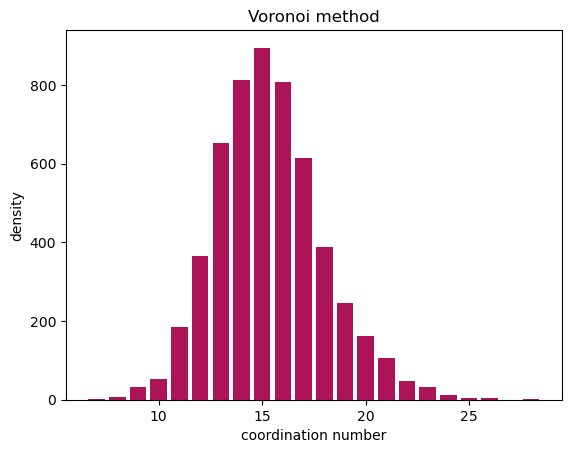

In [86]:
#这是 Voronoi method计算得到的
sys.find.neighbors(method='voronoi')
coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]
nos, counts = np.unique(coordination, return_counts=True)
plt.bar(nos, counts, color="#AD1457")
plt.ylabel("density")
plt.xlabel("coordination number")
plt.title("Voronoi method")

# cutoff 算法
sys.find.neighbors(method='cutoff', cutoff = set_cutoff)
coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]
nos, counts = np.unique(coordination, return_counts=True)
plt.bar(nos, counts, color="#AD1457")
plt.ylabel("density")
plt.xlabel("coordination number")
plt.title("Cutoff method")

In [88]:
# 计算q4和q6 然后采用均值的方法
q4_q6_list = sys.calculate.steinhardt_parameter([4,6], averaged=True)
# 分配值
q4 = q4_q6_list[0]
q6 = q4_q6_list[1]

In [89]:
draw_element = ['F']

In [90]:
results_xyz_q4_q6 = []
for i,i_atom in enumerate(ana_atom_list):
    if i_atom[0] in draw_element:
        #print(i_atom[1],i_atom[2],i_atom[3],q4[i],q6[i])
        results_xyz_q4_q6.append([i_atom[1],i_atom[2],i_atom[3],q4[i],q6[i]])
print(results_xyz_q4_q6[:2])

[[49.5085, 11.3638, 64.0392, 0.11914049456625087, 0.11829254265971675], [47.9915, 27.1594, 61.7728, 0.17057684162099745, 0.08982195472011968]]


In [91]:
q4_critical = 0.18

# 找到 取出中心点

In [93]:
center_xyz = []
z_min = 35.0
for i in data_list:
    if i[0]=='F' and i[-1]>z_min:
        center_xyz.append(i[1:])

In [94]:
len(center_xyz)

744

In [95]:
center_mean = np.mean(center_xyz, axis=0)
print(center_mean)

[52.80279126 25.62058907 54.93648293]


# 找到匹配的F原子

In [97]:
def cal_dis(boxsize,atom_1,atom_2):
    p1,p2,box = np.array(atom_1), np.array(atom_2), np.array(box_size)
    delta = p1-p2
    delta = delta - np.round(delta / box) * box
    return np.linalg.norm(delta)

In [98]:
ana_atom_list[0]

['Na', 28.8226, 63.0026, 5.45032]

In [99]:
ana_atom_list[0]

['Na', 28.8226, 63.0026, 5.45032]

In [100]:
draw_element

['F']

In [101]:
neibor_dis_q4 = []
for i,i_atom in enumerate(ana_atom_list):
    if i_atom[0] in draw_element and i_atom[-1]>z_min:
        dis = cal_dis(boxsize=box_size,atom_1=[i_atom[1],i_atom[2],i_atom[3]],atom_2=center_mean)
        neibor_dis_q4.append([dis,q4[i]])
print(neibor_dis_q4[:1])

[[17.232755079874742, 0.11914049456625087]]


In [102]:
len(q4)

5435

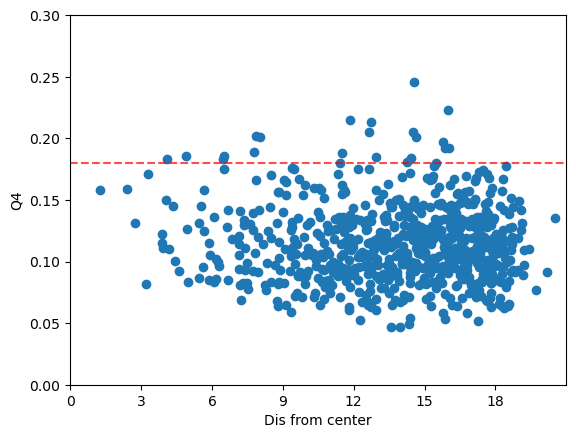

In [104]:
x = [i[0] for i in neibor_dis_q4]
y = [i[1] for i in neibor_dis_q4]
plt.scatter(x,y)
plt.xlim(0,21)
plt.xticks(np.arange(0, 21, 3))
plt.ylim(0,0.3)
plt.xlabel('Dis from center')
plt.ylabel('Q4')
# 添加y=0.18的水平参考线
plt.axhline(y=0.18, color='red', linestyle='--', linewidth=1.5, 
            label='Threshold (y=0.18)', alpha=0.7, zorder=2)
plt.show()

# 得到了所有结果，现在可以可视化分布了

See Origin Figure
Mean q4:  0.1146    Percentage of Q4 > 0.18: 2.92%


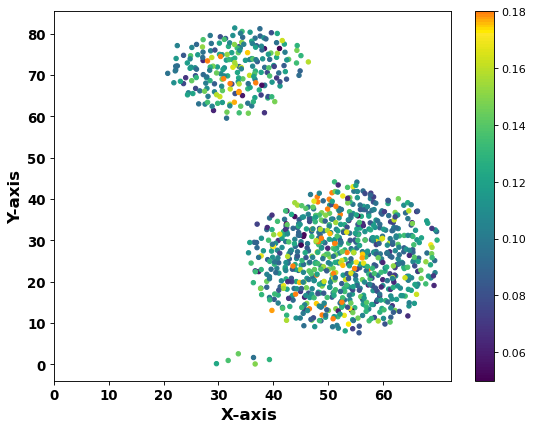

In [107]:
import numpy as np
import matplotlib.pyplot as plt
data_temp = results_xyz_q4_q6
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
# 从 data_list 中提取 x、y、q4 和 q6 数据
x_data = [item[0] for item in data_temp]
y_data = [item[1] for item in data_temp]
q4_data = [item[3] for item in data_temp]
q6_data = [item[4] for item in data_temp]

# 创建二维分布图
plt.figure(figsize=(8, 6) ,dpi=80)

# 绘制 q4 在 x-y 平面上的二维分布图
print('See Origin Figure')

mean_q4 = sum(q4_data)/len(q4_data)
max_q4 = 0
for i in q4_data:
    if i>q4_critical:
        max_q4+=1
print('Mean q4:  ' + str(round(mean_q4,4))+f'    Percentage of Q4 > {q4_critical}: '+ str(round(max_q4/len(q4_data)*100,2))+'%')

###########################################
# 定义viridis色谱的底端绿色渐变

viridis_cmap = plt.get_cmap('viridis')

# 生成顶端橙黄色的渐变，使用非常短的橙色段
orange_yellow = ['#ffea00', '#ff7f0e']  # 橙色到黄色的 HEX 色码，顺序调整为黄色到橙色
orange_yellow_cmap = LinearSegmentedColormap.from_list('orange_yellow', orange_yellow, N=8)

# 合并两个色谱，创建自定义色谱
colors = np.vstack((viridis_cmap(np.linspace(0, 1, 128)),
                    orange_yellow_cmap(np.linspace(0, 1, 8))))  # 使用非常短的橙色段
custom_cmap = ListedColormap(colors)
###########################################################

name_x = file_path.split('\\')[-1]
# 绘制 q4 在 x-y 平面上的二维分布图
title_name = name_x+ '(' + str( ana_frame) + 'ns) '

#plt.title(title_name , fontsize=15, fontweight='bold')  #+ str(ana_frame), fontsize=16, fontweight='bold')  # 设置标题字体大小和加粗

################
plt.scatter(x_data, y_data, s=15, c=q4_data, cmap=custom_cmap, marker='o',vmin=0.05, vmax=0.18)
plt.colorbar()
# plt.title('O' , fontsize=15, fontweight='bold')  #+ str(ana_frame), fontsize=16, fontweight='bold')  # 设置标题字体大小和加粗
plt.xlabel('X-axis ', fontsize=15, fontweight='bold')  # 设置 x 轴标签字体大小和加粗
plt.ylabel('Y-axis', fontsize=15, fontweight='bold')  # 设置 y 轴标签字体大小和加粗

# 设置 x 轴刻度值的字体大小、颜色和加粗
plt.xticks(range(0, int(max(x_data)) + 1, 10), fontsize=12, fontweight='bold')
# 设置 y 轴刻度值的字体大小、颜色和加粗
plt.yticks(fontsize=12, fontweight='bold')

# 参考线
# # 添加X参考线
# plt.axvline(x=20, color='black', linestyle='-')  
# plt.axvline(x=40, color='black', linestyle='-')  
# plt.axvline(x=60, color='black', linestyle='-') 
# plt.axvline(x=80, color='black', linestyle='-')
# # 添加Y参考线
# plt.axhline(y=20, color='black', linestyle='-') 
# plt.axhline(y=40, color='black', linestyle='-') 
# plt.axhline(y=60, color='black', linestyle='-') 
# plt.axhline(y=80, color='black', linestyle='-') 
# #plt.xticks(np.arange(0, 95, 20))
#plt.yticks(np.arange(0, 95, 20))

# 显示图形
plt.show()


In [117]:
data = results_xyz_q4_q6.copy()

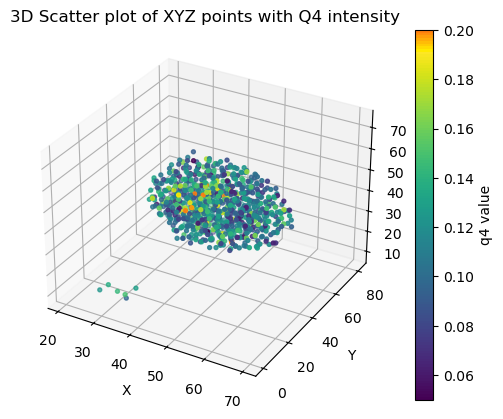

In [119]:
data = np.array(data)
# 提取xyz坐标和q4数据
xyz = np.array([d[:3] for d in data])  # 提取x, y, z
q4_i = np.array([d[3] for d in data])  # 提取q4

# 创建一个自定义的颜色映射
#custom_cmap = cm.viridis  # 使用'viridis'颜色映射

# 创建3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图
scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=q4_i, cmap=custom_cmap, marker='o',s=8, vmin=0.05, vmax=0.2)

# 添加颜色条
fig.colorbar(scatter, ax=ax, label='q4 value')

# 添加标题和坐标轴标签
ax.set_title('3D Scatter plot of XYZ points with Q4 intensity')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.show()


Mean q4:  0.1146    Percentage of Q4 > 0.155: 10.21%


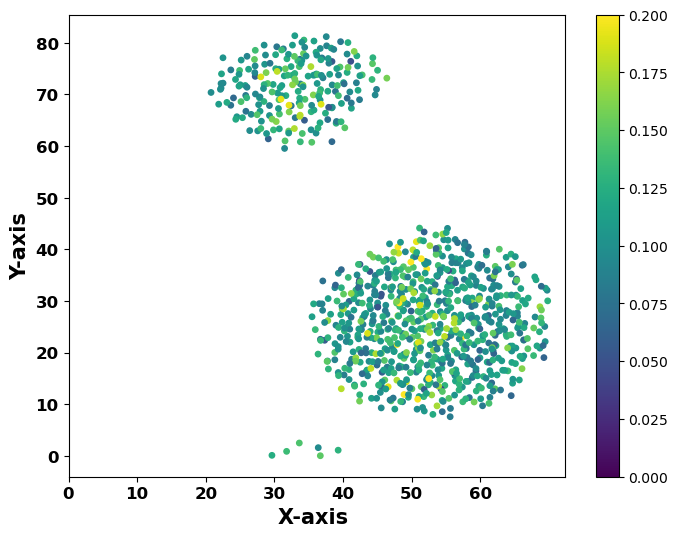

In [122]:
import numpy as np
import matplotlib.pyplot as plt
data_temp = results_xyz_q4_q6

# 从 data_list 中提取 x、y、q4 和 q6 数据
x_data = [item[0] for item in data_temp]
y_data = [item[1] for item in data_temp]
q4_data = [item[3] for item in data_temp]
q6_data = [item[4] for item in data_temp]

mean_q4 = sum(q4_data)/len(q4_data)
max_q4 = 0
for i in q4_data:
    if i>0.155:
        max_q4+=1
print('Mean q4:  ' + str(round(mean_q4,4))+'    Percentage of Q4 > 0.155: '+ str(round(max_q4/len(q4_data)*100,2))+'%')

# 创建二维分布图
plt.figure(figsize=(8, 6))

# 绘制 q4 在 x-y 平面上的二维分布图
title_name = 'LAS-1800K ' + str(50 + ana_frame) + ' ns'

plt.scatter(x_data, y_data, s=15, c=q4_data, cmap='viridis', marker='o',vmin=0.0, vmax=0.20)
plt.colorbar()
# plt.title(title_name , fontsize=15, fontweight='bold')  #+ str(ana_frame), fontsize=16, fontweight='bold')  # 设置标题字体大小和加粗
plt.xlabel('X-axis ', fontsize=15, fontweight='bold')  # 设置 x 轴标签字体大小和加粗 
plt.ylabel('Y-axis', fontsize=15, fontweight='bold')  # 设置 y 轴标签字体大小和加粗 

# 设置 x 轴刻度值的字体大小、颜色和加粗
plt.xticks(range(0, int(max(x_data)) + 1, 10), fontsize=12, fontweight='bold')
# 设置 y 轴刻度值的字体大小、颜色和加粗
plt.yticks(fontsize=12, fontweight='bold')

# 显示图形
plt.show()


# ok

In [222]:
sss

NameError: name 'sss' is not defined

In [ ]:
mean_q4 = sum(q4_data)/len(q4_data)
print('Mean q4:' + str(round(mean_q4,4)))

# 计算所有Nb的和O的和Nb+O的所有均值

In [ ]:
draw_element = ['O']
r1_xyz_q4_q6 = []
for i,i_atom in enumerate(ana_atom_list):
    if i_atom[0] in draw_element:
        r1_xyz_q4_q6.append([i_atom[1],i_atom[2],i_atom[3],q4[i],q6[i]])
draw_element = ['O']
r2_xyz_q4_q6 = []
for i,i_atom in enumerate(ana_atom_list):
    if i_atom[0] in draw_element:
        r2_xyz_q4_q6.append([i_atom[1],i_atom[2],i_atom[3],q4[i],q6[i]])

In [ ]:
r1_q4 = sum([i[3] for i in r1_xyz_q4_q6])/len(r1_xyz_q4_q6)
r2_q4 = sum([i[3] for i in r2_xyz_q4_q6])/len(r2_xyz_q4_q6)
all_q4 = (sum([i[3] for i in r1_xyz_q4_q6])+sum([i[3] for i in r2_xyz_q4_q6]))/(len(r1_xyz_q4_q6)+len(r2_xyz_q4_q6))
out_content = '{:.5f} {:.5f} {:.5f}'.format(r1_q4, r2_q4, all_q4)
print(out_content)

In [ ]:
# 自定义 q4 和 q6 的范围
q4_range = [0.16, 1.0]

#########
import numpy as np
import matplotlib.pyplot as plt

# 示例数据，格式为 [x, y, z, q4, q6]
xyz_q4_q6 = results_xyz_q4_q6

# 提取 x、y、q4 和 q6 列
x_values = [item[0] for item in xyz_q4_q6]
y_values = [item[1] for item in xyz_q4_q6]
q4_values = [item[3] for item in xyz_q4_q6]
#q6_values = [item[4] for item in xyz_q4_q6]

# 根据条件筛选数据
filtered_indices = [i for i in range(len(q4_values)) if q4_range[0] <= q4_values[i] <= q4_range[1] ]
filtered_x = [x_values[i] for i in filtered_indices]
filtered_y = [y_values[i] for i in filtered_indices]

print(len(filtered_indices))
# 创建散点图
plt.figure(figsize=(8, 6))
plt.scatter(filtered_x, filtered_y, color='blue', alpha=0.8)
plt.title('Q4>0.16 ', fontsize=18, fontweight='bold')
plt.xlabel('X')
plt.xlim(0,95)
plt.ylim(0,95)
plt.ylabel('Y')


# 添加网格线，设置间隔为1
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5, color='gray', alpha=1)
plt.xticks(np.arange(0, 95, 20))
plt.yticks(np.arange(0, 95, 20))

# 添加X参考线
plt.axvline(x=20, color='black', linestyle='-')  
plt.axvline(x=40, color='black', linestyle='-')  
plt.axvline(x=60, color='black', linestyle='-') 
plt.axvline(x=80, color='black', linestyle='-')
# 添加Y参考线
plt.axhline(y=20, color='black', linestyle='-') 
plt.axhline(y=40, color='black', linestyle='-') 
plt.axhline(y=60, color='black', linestyle='-') 
plt.axhline(y=80, color='black', linestyle='-') 

plt.show()


In [ ]:
list_save = [filtered_x,filtered_y]
# 保存数据到文件
np.savetxt('filtered_data.txt', list_save)

In [ ]:
import matplotlib.pyplot as plt

# 假设 xlist 和 ylist 是你的数据
xlist = [1, 2, 3, 4, 5]
ylist = [2, 3, 5, 7, 11]

# 创建散点图
plt.scatter(xlist, ylist)

# 添加标题和标签
plt.title('Scatter Plot')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

# 显示图形
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据，格式为 [x, y, z, q4, q6]
xyz_q4_q6 = results_xyz_q4_q6

# 提取 x、q4 和 q6 列
x_values = np.array([item[0] for item in xyz_q4_q6])
q4_values = np.array([item[3] for item in xyz_q4_q6])
q6_values = np.array([item[4] for item in xyz_q4_q6])

bins = 1.0

x_min_bin =  min(x_values)
x_max_bin =  max(x_values)
# 自定义 bin 边界数组
custom_bins = np.arange(x_min_bin, x_max_bin+ bins, bins)

# 使用 np.histogram 计算直方图
hist, bin_edges = np.histogram(x_values, bins=custom_bins)

# 使用 np.digitize 将 x 映射到 bins 中的索引
x_bin_indices = np.digitize(x_values, bin_edges)

# 初始化存储均值的数组
q4_mean_values = np.zeros(len(custom_bins) - 1)
q6_mean_values = np.zeros(len(custom_bins) - 1)

# 计算每个 bin 中 q4 和 q6 的均值
for i in range(1, len(custom_bins)):
    q4_mean_values[i - 1] = np.mean(q4_values[x_bin_indices == i])
    q6_mean_values[i - 1] = np.mean(q6_values[x_bin_indices == i])

fig, ax1 = plt.subplots(figsize=(8, 6))

# 绘制均值随 x 的一维变化，改为折线图
ax1.set_xlabel('X-axis', fontsize=20, fontweight='bold')  # 设置 x 轴标签字体大小和加粗
ax1.set_ylabel('Mean Q4', color='tab:red', fontsize=20, fontweight='bold')  # 设置 y 轴标签字体大小、颜色和加粗
ax1.plot(bin_edges[:-1], q4_mean_values, color='tab:red', marker='o', linestyle='-', linewidth=2, markersize=4)
ax1.tick_params(axis='y', labelcolor='tab:red', labelsize=20)  # 设置 y 轴刻度字体大小
ax1.tick_params(axis='x',  labelsize=20)  # 设置 x 轴刻度字体大小
print(str(ana_frame))
fig.tight_layout()
plt.show()

In [ ]:
ddddddd

In [ ]:
# 自定义 q4 和 q6 的范围
q4_range = [0.1, 1.0]
q6_range = [0.0, 1.0]

In [ ]:
x_origin =np.array([580,595,648,887,1171,1633,2262,2244,1599,799,580])

In [ ]:
x_origin

In [ ]:
x_origin =np.array([580,595,648,887,1171,1633,2262,2244,1599,799,580])

for i in x_origin:
    print((i-580)/(2262-580))